# INM705 Coursework
## Semantic Segmentation of Brain Tumours using 3D U-Net and Fully Convolutional Network 
### Aaron Mir (Student Number: 160001207) and Sarah Rhalem (Student Number: 190051884)

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import nibabel as nib
from nibabel.testing import data_path
# importing packages for visualisation and pre-processing
import SimpleITK as sitk
import time
import itk                  # visualisation in jupyter
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as tf
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.utils.data as data
from torch.cuda import amp
from tqdm import tqdm

In [2]:
##--------------------Coding References---------------------##
# Percentage of borrowed code: X% - 
# [1] 

In [3]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Nibabel Version: {nib.__version__}")
print(f"SITK Version: {sitk.__version__}")

Python: 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
Numpy Version: 1.19.5
PyTorch Version: 1.7.1+cu110
Nibabel Version: 3.2.1
SITK Version: 2.1.0.dev156


## Initial investigation of the first training image

In [20]:
image_1 = os.path.join('data\\train\\BRATS_001.nii.gz') # accessing the first training image
image_1 = nib.load(image_1) # loading the training image

In [21]:
image_1.shape # looking at the shape (240x240 pixels), 155 frames, 4 dimensions (FLAIR, T1w, T1gd, T2w)

(240, 240, 155, 4)

In [22]:
print(image_1) # looking at the header

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155, 4)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quater

In [23]:
image_1_data = image_1.get_fdata()  # transforming to np array - don't need to use np.asarray necessarily 

In [26]:
image_1_data.shape # looking at the shape

(240, 240, 155, 4)

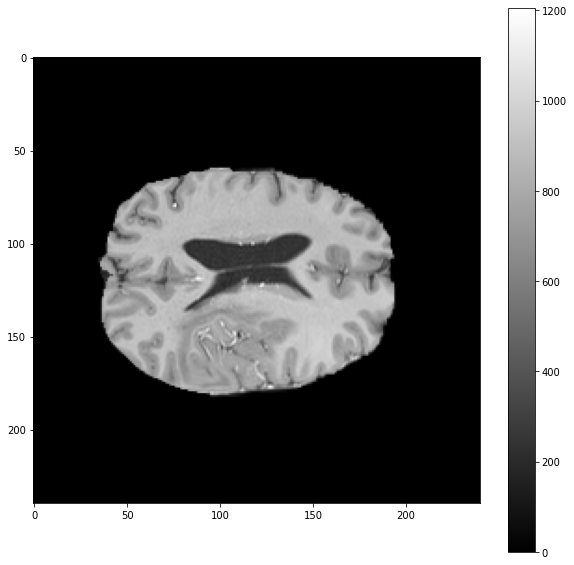

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image_1_data[:,:,95,2], cmap='gray') # plotting the FLAIR (0th dimension) of the 106th frame of the 1st training image FLAIR - 0, T1w - 1, T1gd - 2, T2w - 3
plt.colorbar();

## Initial investigation of the label for the first training image

In [38]:
image_1_label = os.path.join('data\\train_labels\\BRATS_001.nii.gz') # accessing the label for the first training image
image_1_label = nib.load(image_1_label) # loading the label for the first training image

In [39]:
image_1_label.shape # investigating the shape (240x240 pixels), 155 frames each frame represents the pixels where the tumour is present as demonstrated below 

(240, 240, 155)

In [40]:
print(image_1_label) # looking at the header for the label

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c   

In [41]:
image_1_label_data = image_1_label.get_fdata() # transforming to np array - don't need to use np.asarray necessarily

In [42]:
image_1_label_data.shape # investigating the shape

(240, 240, 155)

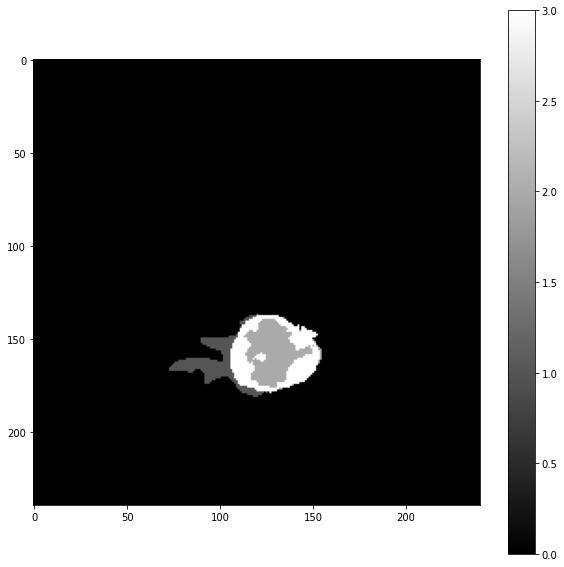

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image_1_label_data[:,:,55], cmap='gray') # plotting the label of the 1st training image - 55th frame shows clearly the tumour and 0-3 represents tumour class
plt.colorbar();

## Data Preprocessing

Summary of steps to perform: 
- N4ITK bias correction - DONE
- Normalise to 0 mean and unit variance - DONE
- 1% of the top and bottom intensities removed - DONE
- Data Augmentation (rotation, shearing etc.) to generate more data points from 484 Labelled MRIs with tumours, helps with generalisation - DONE
- Train/val/test split - DONE

In [22]:
image_1 = os.path.join('data\\train\\BRATS_001.nii.gz') # accessing the first training image
image_1 = nib.load(image_1) # loading the training image
image_1_data = image_1.get_fdata() # converting to np array

In [25]:
height, width, depth, channels = image_1_data.shape         # getting the dimensions
print(f'This image has the following dimensions: \nHeight = {height}\nWidth = {width}\nDepth = {depth}\nChannels = {channels}')

This image has the following dimensions: 
Height = 240
Width = 240
Depth = 155
Channels = 4


In [26]:
def visualisation(layer):                   # function that allows interaction to view all layers of an MRI
    plt.figure(figsize=(5,5))
    channel = 0
    plt.imshow(image_1_data[:,:, layer, channel], cmap='gray')
    plt.title('Visualisation of Layers of Brain MRI', family='Arial', fontsize=20)
    plt.axis('off')
    return layer

interact(visualisation, layer = (0, image_1_data.shape[2]-1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [27]:
## Doing the same as above for the labels
image_1_label = os.path.join('data\\train_labels\\BRATS_001.nii.gz') # accessing the label for the first training image
image_1_label = nib.load(image_1_label) # loading the label for the first training image
image_1_label_data = image_1_label.get_fdata()

In [28]:
height, width, depth = image_1_label_data.shape         # getting the dimensions
print(f'This image has the following dimensions: \nHeight = {height}\nWidth = {width}\nDepth = {depth}.')
print(f'With the unique values: {np.unique(image_1_label_data)}.')
print('''Corresponding to the label categories:             
 0: for normal,
 1: for edema,
 2: for non-enhancing tumour
 3: for enhancing tumour''')                            # outlining the labels

This image has the following dimensions: 
Height = 240
Width = 240
Depth = 155.
With the unique values: [0. 1. 2. 3.].
Corresponding to the label categories:             
 0: for normal,
 1: for edema,
 2: for non-enhancing tumour
 3: for enhancing tumour


In [29]:
classes = {
    'Normal' : 0.,
    'Edema' : 1.,
    'Non-enhancing Tumour' : 2.,
    'Enhancing Tumour' : 3.,
}
select_class = ToggleButtons(
    options = ['Normal','Edema', 'Non-enhancing Tumour', 'Enhancing Tumour'],
    description = 'Select Class:',
    disabled = False,
    button_style = 'info', 
    
)
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes[seg_class]
    mask = np.where(image_1_label_data[:,:, layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

interactive(plot_image, seg_class = select_class, layer = select_layer) # remember the white space represents what is being shown

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

#### Exploring N4 Bias Correction:

N4ITK paper : https://ieeexplore.ieee.org/abstract/document/5445030

Documentation: https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html

#### Note for Sarah: The N4 Bias correction from file doesn't work properly on 4D images (error with otsuthreshold) so we have to convert to np arrays first before doing N4 bias correction and do it for each of the 4 images per MRI. I can run this and it will take a while but we can save the np arrays for easier access in the future. About your note, I think it is still beneficial to remove the top and bottom 1% intensity removal but I will look into it.

In [45]:
image = sitk.ReadImage('data\\train\\' + 'BRATS_001.nii.gz', sitk.sitkFloat32)
print(image.GetWidth())
print(image.GetHeight())
print(image.GetDepth())
print(image.GetDimension())
print (image.GetPixelIDValue())
print (image.GetPixelIDTypeAsString())

240
240
155
4
8
32-bit float


#### Exploring Otsu Thresholding


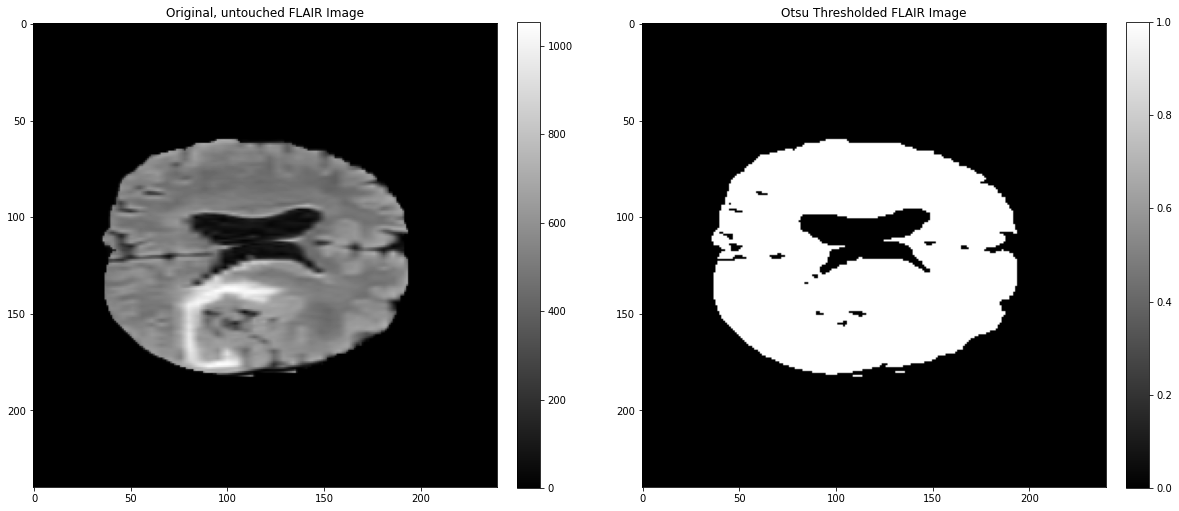

In [3]:
image = sitk.ReadImage('data\\train\\' + 'BRATS_001.nii.gz', sitk.sitkFloat32)    
inputImg_FLAIR = image[:,:,:,0]                                                 # looking at FLAIR only for now
img_orig = sitk.GetArrayViewFromImage(inputImg_FLAIR).T

maskImg_FLAIR = sitk.OtsuThreshold(inputImg_FLAIR, 0, 1, 200)                   # Otsu_Threshold
img_thresholded = sitk.GetArrayViewFromImage(maskImg_FLAIR).T

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].set_title("Original, untouched FLAIR Image")
im1 = ax[0].imshow(img_orig[:,:,95], cmap='gray')
fig.colorbar(im1, ax = ax[0], fraction=0.046, pad=0.04)

ax[1].set_title("Otsu Thresholded FLAIR Image")
im2 = ax[1].imshow(img_thresholded[:,:,95], cmap='gray') 
fig.colorbar(im2, ax = ax[1], fraction=0.046, pad=0.04)
plt.show()

#### N4 Bias Correction

In [5]:
def N4_Bias_Correct_All(src_dir, out_dir):         
    # Bias correction takes very long. Accesses an individual channel/modality, performs bias correction and then savesthis as the FLAIR or T1w or T2w or T1gd file.
    print('Performing N4 Bias Correction...')
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    for data in os.listdir(src_dir): 
        image = sitk.ReadImage(src_dir + str(data), sitk.sitkFloat32)
          
        inputImg_FLAIR = image[:,:,:,0]                                                                                         
        maskImg_FLAIR = sitk.OtsuThreshold(inputImg_FLAIR, 0, 1, 200)
        outputImg_FLAIR = corrector.Execute(inputImg_FLAIR, maskImg_FLAIR)                   # performing N4 bias correction and normalisation for FLAIR image               
        sitk.WriteImage(outputImg_FLAIR, out_dir + '\\' + str(data)[:9] + '\\' + 'FLAIR_' + str(data))
        time.sleep(5)

        inputImg_T1w = image[:,:,:,1]                                                                                       
        maskImg_T1w = sitk.OtsuThreshold(inputImg_T1w, 0, 1, 200)
        outputImg_T1w = corrector.Execute(inputImg_T1w, maskImg_T1w)                         # performing N4 bias correction and normalisation for T1w image
        sitk.WriteImage(outputImg_T1w, out_dir + '\\' + str(data)[:9] + '\\' + 'T1w_' + str(data))

        inputImg_T1gd  = image[:,:,:,2]                                                          
        maskImg_T1gd = sitk.OtsuThreshold(inputImg_T1gd, 0, 1, 200)
        outputImg_T1gd = corrector.Execute(inputImg_T1gd, maskImg_T1gd)                      # performing N4 bias correction and normalisation for T1gd image
        sitk.WriteImage(outputImg_T1gd, out_dir + '\\' + str(data)[:9] + '\\' + 'T1gd_' + str(data))
    
        inputImg_T2w  = image[:,:,:,3]                                                            
        maskImg_T2w = sitk.OtsuThreshold(inputImg_T2w, 0, 1, 200)
        outputImg_T2w = corrector.Execute(inputImg_T2w, maskImg_T2w)                         # performing N4 bias correction and normalisation for T2w image
        sitk.WriteImage(outputImg_T2w, out_dir + '\\' + str(data)[:9] + '\\' + 'T2w_' + str(data))        
        time.sleep(5)

In [6]:
start = time.time() 
N4_Bias_Correct_All(src_dir='data\\train\\', out_dir='data\\pre-processed_data\\train')
end = time.time()
print('time taken =', end-start)

N4 bias correction starting...
time taken = 11458.428798437119


In [8]:
def Filter_All(src_dir, out_dir):     
    # Saturates the top 1% and bottom 1% of intensities from N4 Bias-Corrected images and then normalises to zero mean and unit variance and overwrites them in the pre-processed_data folder. 
    print('Performing Intensity Filtering and Normalisation...')
    intensityFilter = sitk.RescaleIntensityImageFilter()
    normaliseFilter = sitk.NormalizeImageFilter()
    for folder in os.listdir(src_dir): 
        for data in os.listdir(src_dir + '\\' + str(folder)):
            inputImg = sitk.ReadImage(src_dir + '\\' + str(folder) + '\\' + str(data), sitk.sitkFloat32)           # accessing training image
            image_arr = sitk.GetArrayFromImage(inputImg).T  
            minimum, maximum = np.percentile(image_arr, (1, 99))
            intensityFilter.SetOutputMinimum(minimum)
            intensityFilter.SetOutputMaximum(maximum)
            outputImg = intensityFilter.Execute(inputImg)                                                          # apply intensity filter
            outputImg = normaliseFilter.Execute(outputImg)                                                         # apply normalisation filter
            sitk.WriteImage(outputImg, out_dir + '\\' + str(folder) + '\\' + str(data))

In [9]:
start = time.time() 
Filter_All(src_dir='data\\pre-processed_data\\train', out_dir='data\\pre-processed_data\\train\\')       # Normalisation of training images - overwrites the Bias corrected images
end = time.time()
print('time taken =', end-start)

Performing Intensity Filtering and Normalisation...
time taken = 1423.9136998653412


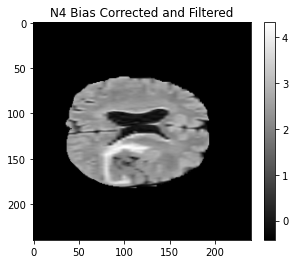

In [20]:
image_1 = os.path.join('data\\pre-processed_data\\train\\BRATS_001\\FLAIR_BRATS_001.nii.gz') 
image_1 = nib.load(image_1) 
image_1 = image_1.get_fdata()
plt.imshow(image_1[:,:,95], cmap='gray')
plt.title("N4 Bias Corrected and Filtered")
plt.colorbar(fraction=0.046, pad=0.04)


### Brats Dataset Class

* Custom dataset class for Brats dataset, transforms image/label to tensor and centre crops images to reduce background size
* Random split of Brats dataset into Train, Validation and Test subsets
* Data augmentation performed on train subset to increase training dataset size 3x- Flip Transform & Random Affine augmentations

In [2]:
# Dataset class to load all pre-processed data (N4 corrected files), transform to tensor and crop background 
# to reduce size prior to train/val/test splitting.

class BratsDataset(data.Dataset):
    def __init__ (self, img_dir, label_dir, seed=0):
        self.img_dir = img_dir
        self.label_dir = label_dir
        torch.manual_seed(seed)
        
    def load_img(self, idx): # must call the transform method in here fyi
        vectorOfImages = sitk.VectorOfImage()
        single_image_dir = self.img_dir+os.listdir(self.img_dir)[idx]+'\\'
        
        for data in os.listdir(single_image_dir):                            
            vectorOfImages.push_back(sitk.ReadImage(single_image_dir+str(data)))

        image = sitk.JoinSeries(vectorOfImages)
        img = sitk.GetArrayFromImage(image)
        return img
    
    def load_label(self, idx):
        single_label_dir = self.label_dir + os.listdir(self.label_dir)[idx]
        image_label = sitk.ReadImage(single_label_dir)
        label = sitk.GetArrayFromImage(image_label)
        return label
    
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, idx):
        X_image = self.load_img(idx)
        y_label = self.load_label(idx)        
        X_image, y_label = self.transform_img(X_image, y_label)
        return X_image, y_label
    
    def transform_img(self, input_img, label_img):  
        X = torch.tensor(input_img[:,17:129,:,:])         # crop out slices that don't have info - produces 128 remaining slices
        y = torch.tensor(label_img[17:129,:,:])
        transform = transforms.Compose([
            transforms.CenterCrop(160),
            ])                      # Crops background of brats images from 240 x 240 to 160x160 # try 156
                                    
        X = transform(X)
        y = transform(y)
        return X, y
    
# Class for train subset which undergoes data augmentation to increase training dataset size.
# Generates two augmented images and corresponding labels per original Brats image and orders them by index.
class TrainBratsDataSubset(data.dataset.Subset):
    def __init__(self, data_subset, data_augmentation=[]):
        self.subset = data_subset
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.subset.indices)*(1+len(self.data_augmentation))
    
    def __getitem__(self, idx):
        img_idx = idx
        t_augmentation = None
        
        if(len(self.data_augmentation) != 0):               #case we are doing data augmentation
            img_idx = idx//(1+len(self.data_augmentation))
            aug_idx = idx%(1+len(self.data_augmentation))
            if(aug_idx!=0):
                t_augmentation = self.data_augmentation[aug_idx-1]
            
        X_image = self.subset.dataset.load_img(self.subset.indices[img_idx])
        y_label = self.subset.dataset.load_label(self.subset.indices[img_idx])
        
        X_image, y_label = self.subset.dataset.transform_img(X_image,y_label)
        if(t_augmentation != None):
            X_image, y_label = t_augmentation(X_image,y_label)  
        return X_image, y_label

class AugmentationTransform: #Base class for the augmentation transforms
    def __call__(self, X_image, y_label):
        raise ValueError("ImageTransforms.__call__() not implemented on AugmentationTransform")
        return

class FlipTransform(AugmentationTransform):#flips horizontaly or verticaly given a probability 
    def __init__(self, p=0.5, seed=0): # probability set to 0.5
        self.p = p
        self.rng = np.random.default_rng(seed=seed)
    
    def __call__(self, X_image, y_label):
        if(self.rng.choice(a = [0,1], p = [self.p, 1-self.p]) == 0):
            #horizontal
            hflip = transforms.RandomHorizontalFlip(p=1)
            return hflip(X_image),hflip(y_label)
        else:
            #vertical
            vflip = transforms.RandomVerticalFlip(p=1)
            return vflip(X_image), vflip(y_label)

class RandomAffine(AugmentationTransform): # Performs random affine translations of the image keeping centre invariant(rotation and shear(image distortion))
    def __init__(self, degrees = 90, translate = None, scale = None, shear = [0.2, 0.2], seed=0): 
        self.degrees = degrees  # rotates image randomly between 0.5 * degrees and 1.5 * degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear # shears image randomly on x-axis between 0.5 *shear[0] and 1.5*shear[0] and on y-axis  between 0.5 *shear[1] and 1.5*shear[1]
        self.rng = np.random.default_rng(seed = seed)    
    
    def __call__(self,X_image,y_label):
        t_degree = self.degrees *(self.rng.random() + 0.5)
        t_shear = [self.shear[idx]*(self.rng.random() + 0.5) for idx in [0,1]]
        random_affine = transforms.RandomAffine(
            degrees = (t_degree, t_degree),
            translate = self.translate,
            scale = self.scale,
            shear = (t_shear[0], t_shear[0], t_shear[1], t_shear[1]),
         )
        return random_affine(X_image), random_affine(y_label)

# Method to randomly split brats dataset into train, validation and test subsets and process the train subset for data augmentation.    
def random_split_bratsdataset(dataset, data_augmentation = [], t_percent=0.60, v_percent = 0.20, seed = 0):
    len_dataset = dataset.__len__()
    len_train    = int(t_percent*len_dataset)
    len_validate = int((t_percent+v_percent)*len_dataset)-len_train
    lengths = [len_train, len_validate]
    if((t_percent + v_percent)!=1):
        len_test = len_dataset-len_validate-len_train
        lengths += [len_test]
    subsets  = torch.utils.data.random_split(dataset,lengths,torch.Generator().manual_seed(seed))
    subsets[0] = TrainBratsDataSubset(subsets[0], data_augmentation)
    return subsets

# Instatiate instance of the dataset
brats_dataset = BratsDataset('data\\pre-processed_data\\train\\', 'data\\train_labels\\')
# Split data into subsets - train(containing augmented images), validation and test
# Augmentation specified can 
train_subset, validation_subset, test_subset = random_split_bratsdataset(brats_dataset, data_augmentation=[FlipTransform(), RandomAffine()]) 
# Print lengths of subsets
print ("Train set length:" + " " + str(train_subset.__len__()))
print ("Validation set length:" + " " + str(validation_subset.__len__()))
print ("Test set length:" + " " + str(test_subset.__len__()))

Train set length: 870
Validation set length: 97
Test set length: 97


#### Create dataloaders:

In [3]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 2
NUM_EPOCHS = 25
NUM_WORKERS = 0
SCALER = amp.GradScaler()
TRAIN_IMG_DIR = 'data\\pre-processed_data\\train\\'
TRAIN_LABEL_DIR = 'data\\train_labels\\'
# Instantiate dataloaders
train_dataloader = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS) 
val_dataloader = DataLoader(validation_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS) 

## 3D U-Net

Dataloader puts data in the form of batch_size, channel, depth, height, width.

In [4]:
class DoubleConvBlock(nn.Module): # Conv3d would make the features from each frame interact and may learn temporal contexts. 
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, 1, 1, bias=False), # 3x3 kernel, stride 1, padding same
            nn.BatchNorm3d(out_channels), 
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm3d(out_channels), 
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, features=[64, 128, 256, 512]):
        super(UNet3D, self).__init__()
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Down part of UNet - encoder
        for feature in features:                            # adds 4 convblocks
            self.encode.append(DoubleConvBlock(in_channels, feature))   
            in_channels = feature

        # Up part of UNet - decoder
        for feature in reversed(features):
            self.decode.append(nn.ConvTranspose3d(
                    feature*2, feature, kernel_size=2, stride=2,        # upsample
                )
            )
            self.decode.append(DoubleConvBlock(feature*2, feature))     # adds 4 conv blocks using reversed features

        self.bottleneck = DoubleConvBlock(features[-1], features[-1]*2)           # bottleneck
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)                
    
    def forward(self, x):
        skip_connections = []                                   # skip connections skip some layer in the  network and feeds the output of one layer as the input to the next layers (instead of only one)
        for down in self.encode:                                # for every conv block
            x = down(x)
            skip_connections.append(x)                          # append result to skip_connections list
            x = self.pool(x)                                    # apply maxpooling after double conv
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]               # reverse the order of skip connections
 
        for idx in range(0, len(self.decode), 2):               # step of 2
            x = self.decode[idx](x)                             # conv transpose
            skip_connection = skip_connections[idx//2]          # step by 2
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decode[idx+1](concat_skip)
        return self.final_conv(x)

In [5]:
model = UNet3D(in_channels=4, out_channels=4).to(DEVICE) # 1, 4, 144, 192, 192 to 2, 4, 128, 160, 160
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
print(model)         

UNet3D(
  (encode): ModuleList(
    (0): DoubleConvBlock(
      (conv): Sequential(
        (0): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConvBlock(
      (conv): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [6]:
def compute_dice_score(pred, label, classes):
    smooth = 1                                          # avoids division by zero in the scenario where pred and label do not contain foreground pixels
    _preds = torch.exp(torch.log_softmax(pred, dim=1))      # doing the log_softmax then using exponential to get probabilities 
    _preds = (_preds > 0.5).float() 
    _preds[:, 0][_preds[:, 0]==0] = 4                       # changing pixel values to match labels
    _preds[:, 1][_preds[:, 1]==0] = 4
    _preds[:, 2][_preds[:, 2]==0] = 4
    _preds[:, 3][_preds[:, 3]==0] = 4                        
    _preds[:, 0][_preds[:, 0]==1] = 0
    _preds[:, 2][_preds[:, 2]==1] = 2
    _preds[:, 3][_preds[:, 3]==1] = 3 
    _labels = label         
    dice_scores = []
    #dice_loss = []
    for batch in range(_preds.shape[0]):            # iterate over each batch
        for i in range(classes):
            pd = np.equal(_preds[batch].cpu(), i)
            gt = np.equal(_labels[batch].cpu(), i)
            dice = (2*np.logical_and(pd, gt).sum() + smooth)/(pd.sum() + gt.sum() + smooth)    
            dice_scores.append(float(dice))
            #dice_loss.append(1-float(dice))
    return dice_scores #torch.tensor(np.mean(dice_loss)).to(device=DEVICE)  # returns a list containing the dice scores for normal, edema, non-enhancing tumour and enhancing tumour for a batch 

In [7]:
def save_checkpoint(state, filename):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [8]:
# Add training dice score and validation loss and dice score Whole Tumour Core Tumour Active Tumour
# In practice, one would calculate a vector of dice scores per class, take its mean and return 1-mean
def train_val(train_loader, val_loader, model, loss_fn, optimizer, scaler): 
    history_train_loss = []                 # for plotting training, val loss and dice per epoch etc.
    history_val_loss = []
    history_train_dice_epoch = []
    history_val_dice = []
    history_val_dice_epoch = []
    start = time.time()
    for epoch in range(NUM_EPOCHS):
        train_loss_store = [] 
        train_dice_store = []
        model.train()                                       
        for batch_idx, (data, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):    # train
            data = data.to(device=DEVICE, dtype=torch.float)
            labels = labels.to(device=DEVICE, dtype=torch.long) 
            model.zero_grad()
            # forward
            with amp.autocast(): 
                preds = model(data)                         
                train_loss = loss_fn(preds, labels)
                train_dice_scores = compute_dice_score(preds, labels, 4)
            # backward
            optimizer.zero_grad()
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            torch.cuda.empty_cache()
            train_loss_store.append(train_loss.item())
            train_dice_store += train_dice_scores                        
        train_loss_epoch = np.mean(train_loss_store)
        train_dice_epoch = np.mean(train_dice_store)                   
        history_train_loss.append(train_loss_epoch)                     # mean loss per epoch
        history_train_dice_epoch.append(train_dice_epoch)               # mean dice score per class per epoch
        #history_train_dice += train_dice_store                         # saving all dice scores per class - don't really need to save for training set. Too large.

        model.eval()
        val_loss_store = []
        val_dice_store = []
        with torch.no_grad():
            for batch_idx, (data, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):        # val
                data = data.to(device=DEVICE, dtype=torch.float)
                labels = labels.to(device=DEVICE, dtype=torch.long) 
                with amp.autocast():
                    preds = model(data)
                    val_loss = loss_fn(preds, labels)
                    val_dice_scores = compute_dice_score(preds, labels, 4)                
                torch.cuda.empty_cache()
                val_loss_store.append(val_loss.item())
                val_dice_store += val_dice_scores            
        val_loss_epoch = np.mean(val_loss_store)
        val_dice_epoch = np.mean(val_dice_store)
        history_val_loss.append(val_loss_epoch)
        history_val_dice_epoch.append(val_dice_epoch)
        history_val_dice += val_dice_store                              # saving all dice scores per class for validation                          
        
        print(f' epoch: {epoch}, train loss: {train_loss_epoch:.6f}, val loss: {val_loss_epoch:.6f}, train dice: {train_dice_epoch:.4f}, val dice: {val_dice_epoch:.4f}')

        if (epoch % 5==0):
            checkpoint = {
                "state_dict": model.state_dict(), 
                "optimizer": optimizer.state_dict(),}
            save_checkpoint(checkpoint, 'trainedUNet.pth.tar')
            np.save('UNet_train_loss_epoch4.npy', history_train_loss)
            np.save('UNet_val_loss_epoch4.npy', history_val_loss)
            np.save('UNet_train_dice_epoch4.npy', history_train_dice_epoch)
            np.save('UNet_val_dice_epoch4.npy', history_val_dice_epoch)
            np.save('UNet_history_val_dice4.npy', history_val_dice)
    #history_train_dice = np.reshape(history_train_dice, (-1, 4))
    history_val_dice = np.reshape(history_val_dice, (-1, 4))
    end = time.time()
    print('Training and validation has taken ', end - start, 'seconds to complete')
    return history_train_loss, history_val_loss, history_train_dice_epoch, history_val_dice_epoch, history_val_dice

### MAKE SURE NOT TO DELETE OR RUN THE TRAINING CELLS

In [10]:
history_train_loss, history_val_loss, history_train_dice_epoch, history_val_dice_epoch, history_val_dice = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, 'trained.pth.tar')

100%|██████████| 49/49 [02:21<00:00,  2.89s/it]
 epoch: 24, train loss: 0.027682, val loss: 0.039859, train dice: 0.7517, val dice: 0.7184
Training and validation has taken  50113.83005690575 seconds to complete
=> Saving checkpoint


In [12]:
load_checkpoint(torch.load('trained.pth.tar'), model, optimizer)
history_train_loss2, history_val_loss2, history_train_dice_epoch2, history_val_dice_epoch2, history_val_dice2 = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, 'trained.pth.tar'

100%|██████████| 49/49 [02:32<00:00,  3.11s/it]
 epoch: 24, train loss: 0.022148, val loss: 0.037456, train dice: 0.7862, val dice: 0.7536
Training and validation has taken  49732.10985183716 seconds to complete
=> Saving checkpoint


In [9]:
load_checkpoint(torch.load('trained2.pth.tar'), model, optimizer)
history_train_loss3, history_val_loss3, history_train_dice_epoch3, history_val_dice_epoch3, history_val_dice3 = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, 'trained2.pth.tar')

100%|██████████| 49/49 [02:21<00:00,  2.90s/it]
 epoch: 24, train loss: 0.019247, val loss: 0.042736, train dice: 0.8087, val dice: 0.7542
Training and validation has taken  44030.22168278694 seconds to complete
=> Saving checkpoint


In [9]:
load_checkpoint(torch.load('trained.pth.tar'), model, optimizer)
history_train_loss4, history_val_loss4, history_train_dice_epoch4, history_val_dice_epoch4, history_val_dice4 = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
np.save('UNet_train_loss_epoch4.npy', history_train_loss4)
np.save('UNet_val_loss_epoch4.npy', history_val_loss4)
np.save('UNet_train_dice_epoch4.npy', history_train_dice_epoch4)
np.save('UNet_val_dice_epoch4.npy', history_val_dice_epoch4)
np.save('UNet_history_val_dice4.npy', history_val_dice4)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, 'trainedUNet.pth.tar')

  0%|          | 0/435 [00:00<?, ?it/s]

=> Loading checkpoint


100%|██████████| 49/49 [02:12<00:00,  2.70s/it]


 epoch: 0, train loss: 0.018766, val loss: 0.034236, train dice: 0.8095, val dice: 0.7625
=> Saving checkpoint


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 1, train loss: 0.018633, val loss: 0.036849, train dice: 0.8122, val dice: 0.7574


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 2, train loss: 0.018314, val loss: 0.038675, train dice: 0.8144, val dice: 0.7472


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 3, train loss: 0.018494, val loss: 0.035774, train dice: 0.8143, val dice: 0.7451


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 4, train loss: 0.018642, val loss: 0.038011, train dice: 0.8136, val dice: 0.7405


100%|██████████| 49/49 [02:15<00:00,  2.77s/it]


 epoch: 5, train loss: 0.018454, val loss: 0.035234, train dice: 0.8138, val dice: 0.7495
=> Saving checkpoint


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 6, train loss: 0.018162, val loss: 0.048808, train dice: 0.8154, val dice: 0.7518


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 7, train loss: 0.018033, val loss: 0.035927, train dice: 0.8165, val dice: 0.7601


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 8, train loss: 0.018342, val loss: 0.034521, train dice: 0.8144, val dice: 0.7563


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 9, train loss: 0.018496, val loss: 0.034030, train dice: 0.8153, val dice: 0.7659


100%|██████████| 49/49 [02:21<00:00,  2.88s/it]


 epoch: 10, train loss: 0.018018, val loss: 0.037198, train dice: 0.8164, val dice: 0.7634
=> Saving checkpoint


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 11, train loss: 0.017768, val loss: 0.034584, train dice: 0.8188, val dice: 0.7645


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 12, train loss: 0.017679, val loss: 0.035185, train dice: 0.8195, val dice: 0.7625


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 13, train loss: 0.017681, val loss: 0.038380, train dice: 0.8201, val dice: 0.7456


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 14, train loss: 0.017463, val loss: 0.035162, train dice: 0.8216, val dice: 0.7660


100%|██████████| 49/49 [02:21<00:00,  2.89s/it]


 epoch: 15, train loss: 0.017205, val loss: 0.035347, train dice: 0.8227, val dice: 0.7609
=> Saving checkpoint


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 16, train loss: 0.017463, val loss: 0.035196, train dice: 0.8218, val dice: 0.7649


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 17, train loss: 0.017086, val loss: 0.037149, train dice: 0.8249, val dice: 0.7535


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 18, train loss: 0.017047, val loss: 0.036853, train dice: 0.8254, val dice: 0.7634


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 19, train loss: 0.017527, val loss: 0.036146, train dice: 0.8225, val dice: 0.7637


100%|██████████| 49/49 [02:22<00:00,  2.91s/it]


 epoch: 20, train loss: 0.016897, val loss: 0.037096, train dice: 0.8275, val dice: 0.7651
=> Saving checkpoint


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 21, train loss: 0.016778, val loss: 0.036305, train dice: 0.8271, val dice: 0.7617


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 22, train loss: 0.016811, val loss: 0.036188, train dice: 0.8257, val dice: 0.7629


  0%|          | 0/435 [00:00<?, ?it/s]

 epoch: 23, train loss: 0.016658, val loss: 0.037514, train dice: 0.8288, val dice: 0.7554


100%|██████████| 49/49 [02:24<00:00,  2.94s/it]


 epoch: 24, train loss: 0.016862, val loss: 0.037779, train dice: 0.8273, val dice: 0.7496
Training and validation has taken  43973.007895469666 seconds to complete
=> Saving checkpoint


## Evaluation of U-Net - TRAINING

In [16]:
# plot loss curves and mean dice 
UNet_train_loss_epoch = np.load('results/training/UNet_train_loss_epoch.npy')
UNet_val_loss_epoch = np.load('results/training/UNet_val_loss_epoch.npy')
UNet_train_dice_epoch = np.load('results/training/UNet_train_dice_epoch.npy')
UNet_val_dice_epoch = np.load('results/training/UNet_val_dice_epoch.npy')
UNet_val_dice = np.load('results/training/UNet_history_val_dice.npy')

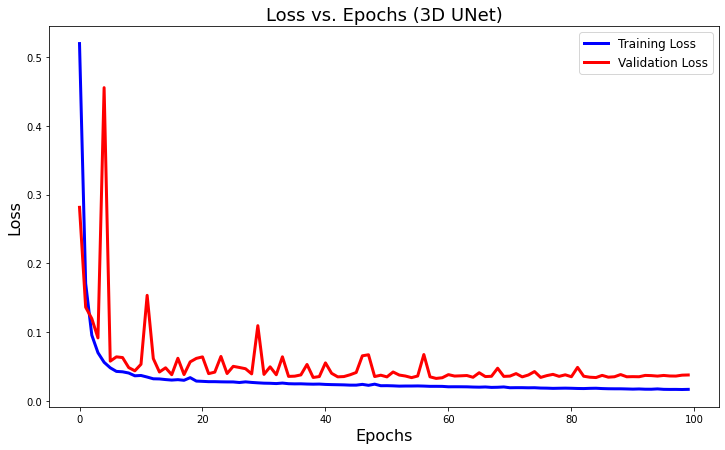

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(UNet_train_loss_epoch, 'b', linewidth=3.0, label='Training Loss')
plt.plot(UNet_val_loss_epoch, 'r', linewidth=3.0, label='Validation Loss')
plt.title('Loss vs. Epochs (3D UNet)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)
# plt.savefig('results/training/LossvsEpochsUNet.png')
plt.show()

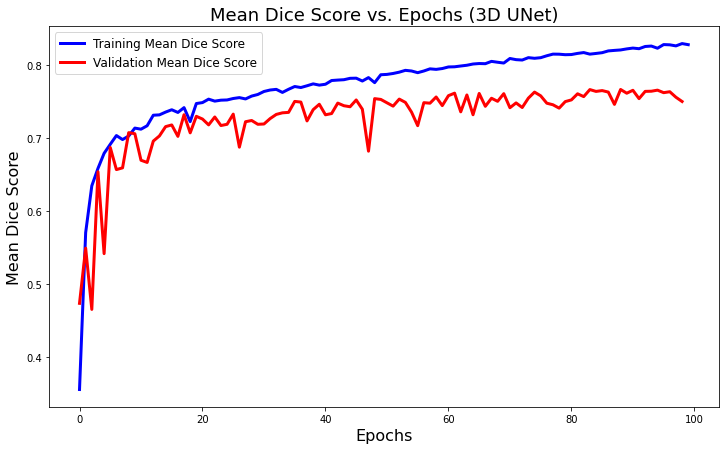

In [14]:
plt.figure(figsize=(12, 7))
plt.plot(UNet_train_dice_epoch, 'b', linewidth=3.0, label='Training Mean Dice Score')
plt.plot(UNet_val_dice_epoch, 'r', linewidth=3.0, label='Validation Mean Dice Score')
plt.title('Mean Dice Score vs. Epochs (3D UNet)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Mean Dice Score', fontsize=16)
plt.legend(fontsize=12)
# plt.savefig('results/training/DicevsEpochsUNet.png')
plt.show()

## Evaluation of U-Net - TESTING

## Metrics for Testing: Dice score, Pixel Sensitivity, Specificity, Hausdorff 95 Distance, Accuracy?
https://www.frontiersin.org/articles/10.3389/fncom.2020.00010/full
<img src="Metrics.png" alt="Metrics" width="700"/>

In [8]:
# USES CPU FOR DEVICE INSTEAD BECAUSE OF MEMORY USAGE ON GPU BEING AROUND ~15GB - USES RAM INSTEAD
DEVICE='cpu' 
LEARNING_RATE = 1e-4
BATCH_SIZE = 2
NUM_WORKERS = 0
SCALER = amp.GradScaler()
train_dataloader = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS) 
val_dataloader = DataLoader(validation_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS) 
model = UNet3D(in_channels=4, out_channels=4).to(DEVICE) # 1, 4, 144, 192, 192 to 2, 4, 128, 160, 160
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
load_checkpoint(torch.load('trained.pth.tar'), model, optimizer)
def test(loader, model, device):
    model.eval()
    with torch.no_grad():
        for data, label in loader:                      # need to change to accomodate batch sizes
            data = data.to(device=DEVICE, dtype=torch.float)
            label = label.to(device=DEVICE, dtype=torch.long) 
            preds_no_softmax = model(data)
            preds_output = torch.exp(torch.log_softmax(preds_no_softmax, dim=1)) # doing the log_softmax then using exponential to get probabilities 
            preds = (preds_output > 0.5).float()            # try merging predictions into one image
            #print(preds_no_softmax)
            #print(preds_output)
            #print(preds)
            print(preds.shape)
            data_image = data.cpu().detach().numpy()
            preds_image = preds.cpu().detach().numpy()
            label_image = label.cpu().detach().numpy()
            fig, ax = plt.subplots(1,6, figsize=(30,30))


            ax[0].set_title("MRI")
            im1 = ax[0].imshow(data_image[0,0,95,:,:], cmap='gray')
            fig.colorbar(im1, ax = ax[0], fraction=0.046, pad=0.04)

            ax[1].set_title("Label")
            im2 = ax[1].imshow(label_image[0,95,:,:], cmap='gray')
            fig.colorbar(im2, ax = ax[1], fraction=0.046, pad=0.04)

            ax[2].set_title("Prediction 0")
            im3 = ax[2].imshow(preds_image[0,0,95,:,:], cmap='gray')
            fig.colorbar(im3, ax = ax[2], fraction=0.046, pad=0.04)
            
            ax[3].set_title("Prediction 1")
            im4 = ax[3].imshow(preds_image[0,1,95,:,:], cmap='gray')
            fig.colorbar(im4, ax = ax[3], fraction=0.046, pad=0.04)

            ax[4].set_title("Prediction 2")
            im5 = ax[4].imshow(preds_image[0,2,95,:,:], cmap='gray')
            fig.colorbar(im5, ax = ax[4], fraction=0.046, pad=0.04)

            ax[5].set_title("Prediction 3")
            im6 = ax[5].imshow(preds_image[0,3,95,:,:], cmap='gray')
            fig.colorbar(im6, ax = ax[5], fraction=0.046, pad=0.04)
            
            plt.show()
            break
            
    model.train()

=> Loading checkpoint


torch.Size([2, 4, 112, 160, 160])


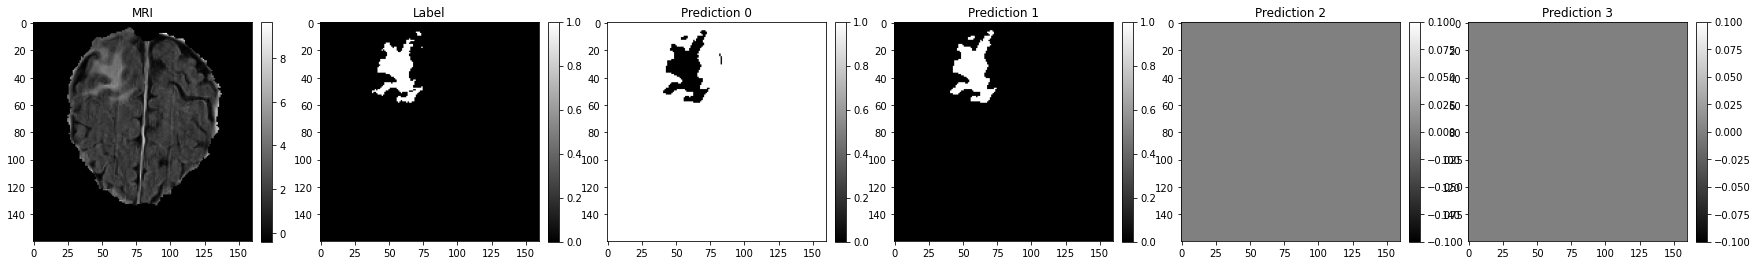

In [9]:
test(test_dataloader, model, device=DEVICE)

In [47]:
def save_predictions(loader, model, folder, device):
    model.eval()
    for idx, (data, label) in enumerate(loader):
        data = data.to(device=device)
        with torch.no_grad():
            preds = torch.log_softmax(model(data))                  

In [19]:
load_checkpoint(checkpoint='/checkpoint2.pth.tar', model=model)
test(val_dataloader, model, device=DEVICE)
print_results(val_dataloader, IMAGE_HEIGHT):
#save_predictions(val_dataloader, model, folder="val_predictions/", device=DEVICE)

In [ ]:
test(test_dataloader, model, device=DEVICE)
save_predictions(test_dataloader, model, folder="test_predictions/", device=DEVICE)

## Fully Convolutional Network

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False), # 3x3 kernel, stride 1, padding same
            nn.BatchNorm3d(out_channels), 
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class TripleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TripleConvBlock, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, 3, 1, 1, bias=False),
                nn.BatchNorm3d(out_channels), 
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
                nn.BatchNorm3d(out_channels), 
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
                nn.BatchNorm3d(out_channels), 
                nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)    
  
class FCN8(nn.Module):
        def __init__(self, in_channels=4, out_channels=4, features=[64, 128, 256, 512, 4096]): # out_channels would be 155 for different segmentation slices? or 4 for the tumour classes?
            super(FCN8, self).__init__()
            self.pool = nn.MaxPool3d(kernel_size=2, stride=2, ceil_mode=False)

            # Conv Block 1 - 2 conv layers
            self.conv1 = DoubleConvBlock(in_channels, out_channels=features[0])
            # Conv Block 2 - 2 conv layers
            self.conv2 = DoubleConvBlock(in_channels=features[0], out_channels=features[1])
            # Conv Block 3 - 3 layers
            self.conv3 = TripleConvBlock(in_channels=features[1], out_channels=features[2])
            # Conv Block 4 - 3 layers
            self.conv4 = TripleConvBlock(in_channels=features[2], out_channels=features[3])
            # Conv Block 5 - 3 layers
            self.conv5 = TripleConvBlock(in_channels=features[3], out_channels=features[3])
            # fc6 - single conv
            self.conv6= ConvBlock(in_channels=features[3], out_channels=features[4], kernel_size=7, padding=3)
            # fc7 - single conv 
            self.conv7= ConvBlock(in_channels=features[4], out_channels=features[4], kernel_size=1, padding=0) 
            # fc8 - single conv
            self.conv8= ConvBlock(in_channels=features[4], out_channels=out_channels, kernel_size=1, padding=0)

            # upsample prediction 
            self.upconv1= nn.ConvTranspose3d(in_channels=4, out_channels=features[3], kernel_size=4, stride=2, padding=1, output_padding=(1,0,0))
            self.upconv2= nn.ConvTranspose3d(in_channels=features[3], out_channels=features[2], kernel_size=4, stride=2, padding=1)
            self.upconv3= nn.ConvTranspose3d(in_channels=features[2], out_channels=out_channels, kernel_size=16, stride=8, padding=4)

        def forward(self, x):
            x= self.pool(self.conv1(x)) 
            x= self.pool(self.conv2(x)) 
            x3= self.pool(self.conv3(x))
            x4=self.pool(self.conv4(x3))
            x= self.pool(self.conv5(x4))
            x= self.conv6(x)
            x= self.conv7(x)
            x= self.conv8(x)
            x= self.upconv1(x)
            x= x4 + x
            x= self.upconv2(x)
            x= x3 + x
            x= self.upconv3(x)

            return x

In [8]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1
NUM_EPOCHS = 100
NUM_WORKERS = 0
SCALER = amp.GradScaler()
TRAIN_IMG_DIR = 'data\\pre-processed_data\\train\\'
TRAIN_LABEL_DIR = 'data\\train_labels\\'
# Instantiate dataloaders
train_dataloader = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS) 
val_dataloader = DataLoader(validation_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS) 
# Instantiate model
model = FCN8(in_channels=4, out_channels=4).to(DEVICE) 
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
history_train_loss, history_val_loss, history_train_dice_epoch, history_val_dice_epoch, history_val_dice = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
np.save('FCN_train_loss_epoch.npy', history_train_loss)
np.save('FCN_val_loss_epoch.npy', history_val_loss)
np.save('FCN_train_dice_epoch.npy', history_train_dice_epoch)
np.save('FCN_val_dice_epoch.npy', history_val_dice_epoch)
np.save('FCN_history_val_dice.npy', history_val_dice)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, filename='trainedFCN.pth.tar')

100%|██████████| 97/97 [02:20<00:00,  1.45s/it]


 epoch: 0, train loss: 0.078918, val loss: 0.229200, train dice: 0.3469, val dice: 0.4236
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 1, train loss: 0.051493, val loss: 0.145398, train dice: 0.4917, val dice: 0.4626


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 2, train loss: 0.045120, val loss: 0.174361, train dice: 0.5700, val dice: 0.5418


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 3, train loss: 0.040384, val loss: 0.114359, train dice: 0.6166, val dice: 0.5521


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 4, train loss: 0.037927, val loss: 0.189850, train dice: 0.6481, val dice: 0.5906


100%|██████████| 97/97 [02:19<00:00,  1.44s/it]


 epoch: 5, train loss: 0.036104, val loss: 0.157821, train dice: 0.6651, val dice: 0.5794
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 6, train loss: 0.035908, val loss: 0.269686, train dice: 0.6694, val dice: 0.5575


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 7, train loss: 0.033763, val loss: 0.319065, train dice: 0.6852, val dice: 0.5786


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 8, train loss: 0.032667, val loss: 0.201139, train dice: 0.6935, val dice: 0.5910


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 9, train loss: 0.031469, val loss: 0.245023, train dice: 0.7021, val dice: 0.6243


100%|██████████| 97/97 [02:04<00:00,  1.28s/it]


 epoch: 10, train loss: 0.030286, val loss: 0.285338, train dice: 0.7098, val dice: 0.6066
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 11, train loss: 0.029675, val loss: 0.211792, train dice: 0.7126, val dice: 0.6229


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 12, train loss: 0.029300, val loss: 0.299348, train dice: 0.7174, val dice: 0.5988


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 13, train loss: 0.030480, val loss: 0.144128, train dice: 0.7163, val dice: 0.6374


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 14, train loss: 0.027882, val loss: 0.201722, train dice: 0.7279, val dice: 0.6337


100%|██████████| 97/97 [02:07<00:00,  1.32s/it]


 epoch: 15, train loss: 0.027339, val loss: 0.460593, train dice: 0.7328, val dice: 0.5916
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 16, train loss: 0.027178, val loss: 0.216983, train dice: 0.7318, val dice: 0.6364


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 17, train loss: 0.026448, val loss: 0.265010, train dice: 0.7401, val dice: 0.6096


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 18, train loss: 0.026145, val loss: 0.282966, train dice: 0.7411, val dice: 0.6207


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 19, train loss: 0.025787, val loss: 0.148517, train dice: 0.7428, val dice: 0.6041


100%|██████████| 97/97 [02:06<00:00,  1.31s/it]


 epoch: 20, train loss: 0.025668, val loss: 0.441816, train dice: 0.7451, val dice: 0.5927
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 21, train loss: 0.024487, val loss: 0.417593, train dice: 0.7521, val dice: 0.5867


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 22, train loss: 0.024674, val loss: 0.674392, train dice: 0.7514, val dice: 0.5610


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 23, train loss: 0.024265, val loss: 0.456717, train dice: 0.7519, val dice: 0.5940


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 24, train loss: 0.023399, val loss: 0.177063, train dice: 0.7591, val dice: 0.6320


100%|██████████| 97/97 [02:17<00:00,  1.41s/it]


 epoch: 25, train loss: 0.023336, val loss: 0.251464, train dice: 0.7608, val dice: 0.6287
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 26, train loss: 0.022876, val loss: 0.351078, train dice: 0.7633, val dice: 0.6191


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 27, train loss: 0.022740, val loss: 0.175820, train dice: 0.7661, val dice: 0.6386


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 28, train loss: 0.022345, val loss: 0.651436, train dice: 0.7684, val dice: 0.5750


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 29, train loss: 0.022407, val loss: 0.372155, train dice: 0.7675, val dice: 0.6191


100%|██████████| 97/97 [02:15<00:00,  1.40s/it]


 epoch: 30, train loss: 0.021746, val loss: 0.664828, train dice: 0.7732, val dice: 0.5783
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 31, train loss: 0.021510, val loss: 0.616756, train dice: 0.7749, val dice: 0.5814


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 32, train loss: 0.021281, val loss: 0.689947, train dice: 0.7762, val dice: 0.5710


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 33, train loss: 0.020928, val loss: 0.775421, train dice: 0.7790, val dice: 0.5702


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 34, train loss: 0.020721, val loss: 0.278987, train dice: 0.7823, val dice: 0.6313


100%|██████████| 97/97 [02:11<00:00,  1.36s/it]


 epoch: 35, train loss: 0.020501, val loss: 0.137481, train dice: 0.7829, val dice: 0.6303
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 36, train loss: 0.020679, val loss: 0.389298, train dice: 0.7821, val dice: 0.6194


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 37, train loss: 0.020049, val loss: 0.533118, train dice: 0.7879, val dice: 0.5833


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 38, train loss: 0.019977, val loss: 0.276251, train dice: 0.7876, val dice: 0.6444


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 39, train loss: 0.019692, val loss: 0.432680, train dice: 0.7902, val dice: 0.6142


100%|██████████| 97/97 [02:10<00:00,  1.35s/it]


 epoch: 40, train loss: 0.019533, val loss: 0.422906, train dice: 0.7924, val dice: 0.6044
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 41, train loss: 0.019421, val loss: 0.555103, train dice: 0.7937, val dice: 0.5813


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 42, train loss: 0.019155, val loss: 0.288348, train dice: 0.7946, val dice: 0.6451


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 43, train loss: 0.019095, val loss: 0.432443, train dice: 0.7972, val dice: 0.5982


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 44, train loss: 0.018838, val loss: 0.487708, train dice: 0.7976, val dice: 0.5961


100%|██████████| 97/97 [02:14<00:00,  1.39s/it]


 epoch: 45, train loss: 0.018696, val loss: 0.755353, train dice: 0.8000, val dice: 0.5743
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 46, train loss: 0.018362, val loss: 0.570016, train dice: 0.8029, val dice: 0.5877


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 47, train loss: 0.018586, val loss: 0.262622, train dice: 0.8017, val dice: 0.6320


  8%|▊         | 72/870 [02:19<26:01,  1.96s/it]

In [9]:
load_checkpoint(torch.load('trainedFCN.pth.tar'), model, optimizer)
torch.cuda.empty_cache()

=> Loading checkpoint


In [10]:
history_train_loss, history_val_loss, history_train_dice_epoch, history_val_dice_epoch, history_val_dice = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
np.save('FCN_train_loss_epoch.npy', history_train_loss)
np.save('FCN_val_loss_epoch.npy', history_val_loss)
np.save('FCN_train_dice_epoch.npy', history_train_dice_epoch)
np.save('FCN_val_dice_epoch.npy', history_val_dice_epoch)
np.save('FCN_history_val_dice.npy', history_val_dice)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, filename='trainedFCN.pth.tar')

100%|██████████| 97/97 [02:00<00:00,  1.24s/it]


 epoch: 0, train loss: 0.018525, val loss: 0.528925, train dice: 0.8017, val dice: 0.5988
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 1, train loss: 0.018216, val loss: 0.302067, train dice: 0.8040, val dice: 0.6304


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 2, train loss: 0.018357, val loss: 0.476938, train dice: 0.8039, val dice: 0.6044


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 3, train loss: 0.018194, val loss: 0.429959, train dice: 0.8058, val dice: 0.6123


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 4, train loss: 0.017983, val loss: 0.415511, train dice: 0.8073, val dice: 0.6131


100%|██████████| 97/97 [02:05<00:00,  1.29s/it]


 epoch: 5, train loss: 0.017840, val loss: 0.344271, train dice: 0.8086, val dice: 0.6304
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 6, train loss: 0.017840, val loss: 0.539374, train dice: 0.8101, val dice: 0.5856


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 7, train loss: 0.017432, val loss: 0.319749, train dice: 0.8117, val dice: 0.6398


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 8, train loss: 0.017401, val loss: 0.340632, train dice: 0.8132, val dice: 0.6317


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 9, train loss: 0.017348, val loss: 0.417304, train dice: 0.8145, val dice: 0.6269


100%|██████████| 97/97 [02:03<00:00,  1.28s/it]


 epoch: 10, train loss: 0.017213, val loss: 0.786168, train dice: 0.8160, val dice: 0.5650
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 11, train loss: 0.017013, val loss: 0.426839, train dice: 0.8154, val dice: 0.6209


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 12, train loss: 0.017293, val loss: 0.833001, train dice: 0.8164, val dice: 0.5682


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 13, train loss: 0.016929, val loss: 0.234587, train dice: 0.8169, val dice: 0.6412


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 14, train loss: 0.016841, val loss: 0.290981, train dice: 0.8186, val dice: 0.6420


100%|██████████| 97/97 [01:56<00:00,  1.20s/it]


 epoch: 15, train loss: 0.016631, val loss: 0.527272, train dice: 0.8212, val dice: 0.6005
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 16, train loss: 0.016682, val loss: 0.340407, train dice: 0.8203, val dice: 0.6290


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 17, train loss: 0.016436, val loss: 0.403367, train dice: 0.8235, val dice: 0.6108


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 18, train loss: 0.016348, val loss: 0.307555, train dice: 0.8232, val dice: 0.6459


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 19, train loss: 0.016211, val loss: 0.350035, train dice: 0.8247, val dice: 0.6124


100%|██████████| 97/97 [02:03<00:00,  1.27s/it]


 epoch: 20, train loss: 0.016226, val loss: 0.473581, train dice: 0.8254, val dice: 0.6112
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 21, train loss: 0.016044, val loss: 0.550710, train dice: 0.8267, val dice: 0.5954


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 22, train loss: 0.015978, val loss: 0.546477, train dice: 0.8272, val dice: 0.5976


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 23, train loss: 0.016163, val loss: 0.661000, train dice: 0.8273, val dice: 0.5835


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 24, train loss: 0.015683, val loss: 0.305460, train dice: 0.8310, val dice: 0.6260


100%|██████████| 97/97 [02:07<00:00,  1.32s/it]


 epoch: 25, train loss: 0.015599, val loss: 0.515007, train dice: 0.8309, val dice: 0.6004
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 26, train loss: 0.015719, val loss: 0.360092, train dice: 0.8304, val dice: 0.6337


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 27, train loss: 0.015530, val loss: 0.307853, train dice: 0.8326, val dice: 0.6420


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 28, train loss: 0.015618, val loss: 0.372461, train dice: 0.8340, val dice: 0.6282


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 29, train loss: 0.015334, val loss: 0.412375, train dice: 0.8334, val dice: 0.6243


100%|██████████| 97/97 [02:01<00:00,  1.25s/it]


 epoch: 30, train loss: 0.015415, val loss: 0.623749, train dice: 0.8338, val dice: 0.5939
=> Saving checkpoint


 39%|███▉      | 338/870 [10:53<17:08,  1.93s/it]


KeyboardInterrupt: 

In [10]:
load_checkpoint(torch.load('trainedFCN.pth.tar'), model, optimizer)
torch.cuda.empty_cache()
history_train_loss, history_val_loss, history_train_dice_epoch, history_val_dice_epoch, history_val_dice = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
np.save('FCN_train_loss_epoch3.npy', history_train_loss)
np.save('FCN_val_loss_epoch3.npy', history_val_loss)
np.save('FCN_train_dice_epoch3.npy', history_train_dice_epoch)
np.save('FCN_val_dice_epoch3.npy', history_val_dice_epoch)
np.save('FCN_history_val_dice3.npy', history_val_dice)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, filename='trainedFCN.pth.tar')

=> Loading checkpoint


100%|██████████| 97/97 [02:05<00:00,  1.29s/it]


 epoch: 0, train loss: 0.015259, val loss: 0.506733, train dice: 0.8352, val dice: 0.6152
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 1, train loss: 0.015120, val loss: 0.404230, train dice: 0.8362, val dice: 0.6123


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 2, train loss: 0.015086, val loss: 0.487637, train dice: 0.8371, val dice: 0.6116


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 3, train loss: 0.015086, val loss: 0.439798, train dice: 0.8374, val dice: 0.6139


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 4, train loss: 0.015023, val loss: 0.617447, train dice: 0.8388, val dice: 0.5939


100%|██████████| 97/97 [02:02<00:00,  1.26s/it]


 epoch: 5, train loss: 0.014945, val loss: 0.373714, train dice: 0.8385, val dice: 0.6323
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 6, train loss: 0.014879, val loss: 0.505039, train dice: 0.8405, val dice: 0.6049


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 7, train loss: 0.014841, val loss: 0.348248, train dice: 0.8404, val dice: 0.6390


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 8, train loss: 0.014694, val loss: 0.336946, train dice: 0.8412, val dice: 0.6346


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 9, train loss: 0.014740, val loss: 0.412516, train dice: 0.8420, val dice: 0.6305


100%|██████████| 97/97 [02:09<00:00,  1.33s/it]


 epoch: 10, train loss: 0.014660, val loss: 0.763895, train dice: 0.8428, val dice: 0.5771
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 11, train loss: 0.014441, val loss: 0.443530, train dice: 0.8431, val dice: 0.6250


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 12, train loss: 0.014668, val loss: 0.636340, train dice: 0.8429, val dice: 0.5915


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 13, train loss: 0.014435, val loss: 0.261476, train dice: 0.8424, val dice: 0.6406


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 14, train loss: 0.014429, val loss: 0.286073, train dice: 0.8451, val dice: 0.6502


100%|██████████| 97/97 [02:20<00:00,  1.45s/it]


 epoch: 15, train loss: 0.014299, val loss: 0.486472, train dice: 0.8461, val dice: 0.6135
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 16, train loss: 0.014292, val loss: 0.374397, train dice: 0.8453, val dice: 0.6289


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 17, train loss: 0.014240, val loss: 0.391678, train dice: 0.8464, val dice: 0.6220


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 18, train loss: 0.014097, val loss: 0.340400, train dice: 0.8468, val dice: 0.6454


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 19, train loss: 0.014087, val loss: 0.401978, train dice: 0.8489, val dice: 0.6126


100%|██████████| 97/97 [02:11<00:00,  1.35s/it]


 epoch: 20, train loss: 0.014108, val loss: 0.526876, train dice: 0.8479, val dice: 0.6109
=> Saving checkpoint


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 21, train loss: 0.014054, val loss: 0.704980, train dice: 0.8491, val dice: 0.5855


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 22, train loss: 0.013857, val loss: 0.590317, train dice: 0.8498, val dice: 0.6032


  0%|          | 0/870 [00:00<?, ?it/s]

 epoch: 23, train loss: 0.013998, val loss: 0.670907, train dice: 0.8498, val dice: 0.5889


100%|██████████| 97/97 [02:10<00:00,  1.34s/it]


 epoch: 24, train loss: 0.013758, val loss: 0.333227, train dice: 0.8517, val dice: 0.6276
Training and validation has taken  45506.11921620369 seconds to complete
=> Saving checkpoint


In [10]:
# plot loss curves and mean dice for FCN
FCN_train_loss_epoch = np.load('results/training/FCN_train_loss_epoch.npy')
FCN_val_loss_epoch = np.load('results/training/FCN_val_loss_epoch.npy')
FCN_train_dice_epoch = np.load('results/training/FCN_train_dice_epoch.npy')
FCN_val_dice_epoch = np.load('results/training/FCN_val_dice_epoch.npy')

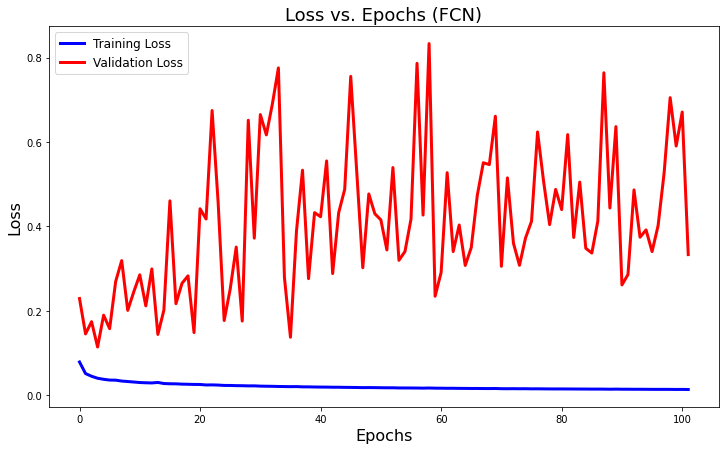

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(FCN_train_loss_epoch, 'b', linewidth=3.0, label='Training Loss')
plt.plot(FCN_val_loss_epoch, 'r', linewidth=3.0, label='Validation Loss')
plt.title('Loss vs. Epochs (FCN)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)
#plt.savefig('results/training/LossvsEpochsFCN.png')
plt.show()

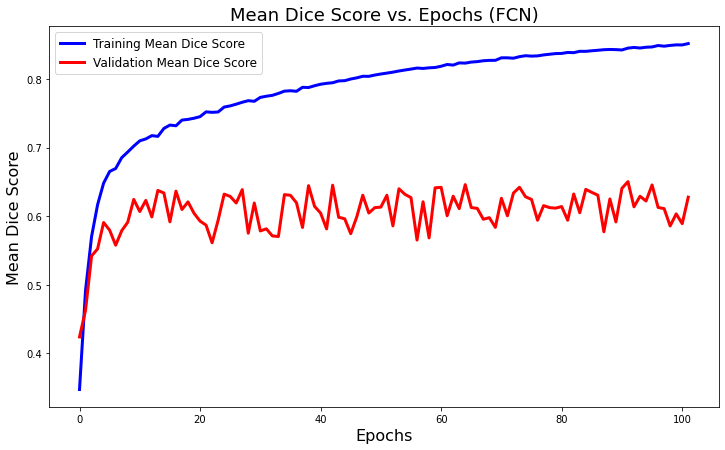

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(FCN_train_dice_epoch, 'b', linewidth=3.0, label='Training Mean Dice Score')
plt.plot(FCN_val_dice_epoch, 'r', linewidth=3.0, label='Validation Mean Dice Score')
plt.title('Mean Dice Score vs. Epochs (FCN)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Mean Dice Score', fontsize=16)
plt.legend(fontsize=12)
#plt.savefig('results/training/DicevsEpochsFCN.png')
plt.show()

## Evaluation of Fully Convolutional Network


In [8]:
# USES CPU FOR DEVICE INSTEAD BECAUSE OF MEMORY USAGE ON GPU BEING AROUND ~15GB - USES RAM INSTEAD
DEVICE='cpu' 
LEARNING_RATE = 1e-4
BATCH_SIZE = 1
NUM_WORKERS = 0
SCALER = amp.GradScaler()
train_dataloader = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS) 
val_dataloader = DataLoader(validation_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS)
test_dataloader = DataLoader(test_subset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS) 
model = FCN8(in_channels=4, out_channels=4).to(DEVICE) # 1, 4, 144, 192, 192 to 2, 4, 128, 160, 160
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
load_checkpoint(torch.load('trainedFCN1.pth.tar'), model, optimizer)
def test(loader, model, device):
    model.eval()
    with torch.no_grad():
        for data, label in loader:                      # need to change to accomodate batch sizes
            data = data.to(device=DEVICE, dtype=torch.float)
            label = label.to(device=DEVICE, dtype=torch.long) 
            preds_no_softmax = model(data)
            preds_output = torch.exp(torch.log_softmax(preds_no_softmax, dim=1)) # doing the log_softmax then using exponential to get probabilities 
            preds = (preds_output > 0.5).float()            # try merging predictions into one image
            #print(preds_no_softmax)
            #print(preds_output)
            #print(preds)
            print(preds.shape)
            data_image = data.cpu().detach().numpy()
            preds_image = preds.cpu().detach().numpy()
            label_image = label.cpu().detach().numpy()
            fig, ax = plt.subplots(1,6, figsize=(30,30))


            ax[0].set_title("MRI")
            im1 = ax[0].imshow(data_image[0,0,95,:,:], cmap='gray')
            fig.colorbar(im1, ax = ax[0], fraction=0.046, pad=0.04)

            ax[1].set_title("Label")
            im2 = ax[1].imshow(label_image[0,95,:,:], cmap='gray')
            fig.colorbar(im2, ax = ax[1], fraction=0.046, pad=0.04)

            ax[2].set_title("Prediction 0")
            im3 = ax[2].imshow(preds_image[0,0,95,:,:], cmap='gray')
            fig.colorbar(im3, ax = ax[2], fraction=0.046, pad=0.04)
            
            ax[3].set_title("Prediction 1")
            im4 = ax[3].imshow(preds_image[0,1,95,:,:], cmap='gray')
            fig.colorbar(im4, ax = ax[3], fraction=0.046, pad=0.04)

            ax[4].set_title("Prediction 2")
            im5 = ax[4].imshow(preds_image[0,2,95,:,:], cmap='gray')
            fig.colorbar(im5, ax = ax[4], fraction=0.046, pad=0.04)

            ax[5].set_title("Prediction 3")
            im6 = ax[5].imshow(preds_image[0,3,95,:,:], cmap='gray')
            fig.colorbar(im6, ax = ax[5], fraction=0.046, pad=0.04)
            
            plt.show()
            break
            
    model.train()

=> Loading checkpoint


torch.Size([1, 4, 112, 160, 160])


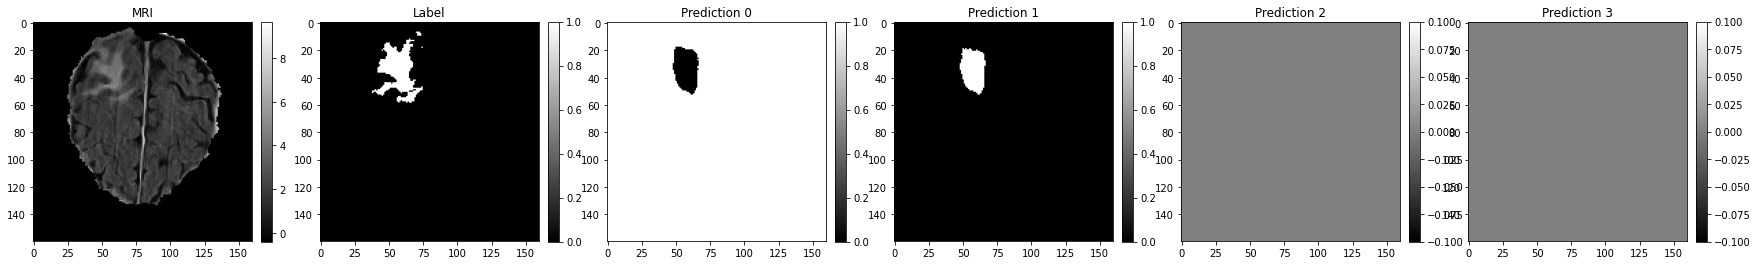

In [9]:
test(test_dataloader, model, device=DEVICE)

## AARON'S IGNORE SECTION

In [ ]:
FCN_train_loss = np.concatenate((np.load('FCN_train_loss_epoch1.npy'), history_train_loss2))
FCN_val_loss = np.concatenate((np.load('FCN_val_loss_epoch1.npy'), history_val_loss2))
FCN_train_dice = np.concatenate((np.load('FCN_train_dice_epoch1.npy'), history_train_dice_epoch2))
FCN_val_dice = np.concatenate((np.load('FCN_val_dice_epoch1.npy'), history_val_dice_epoch2))
FCN_history_val_dice = np.concatenate((np.load('FCN_history_val_dice1.npy), history_val_dice2))
np.save('FCN_train_loss_epochfinal.npy', FCN_train_loss)
np.save('FCN_val_loss_epochfinal.npy', FCN_val_loss)
np.save('FCN_train_dice_epochfinal.npy', FCN_train_dice)
np.save('FCN_val_dice_epochfinal.npy', FCN_val_dice)
np.save('FCN_history_val_dicefinal.npy', FCN_history_val_dice)

In [ ]:
#load_checkpoint(torch.load('trainedFCN1.pth.tar'), model, optimizer)
history_train_loss2, history_val_loss2, history_train_dice_epoch2, history_val_dice_epoch2, history_val_dice2 = train_val(train_dataloader, val_dataloader, model, loss_fn, optimizer, SCALER)
np.save('FCN_train_loss_epoch2.npy', history_train_loss2)
np.save('FCN_val_loss_epoch2.npy', history_val_loss2)
np.save('FCN_train_dice_epoch2.npy', history_train_dice_epoch2)
np.save('FCN_val_dice_epoch2.npy', history_val_dice_epoch2)
np.save('FCN_history_val_dice2.npy', history_val_dice2)
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimizer": optimizer.state_dict(),}
save_checkpoint(checkpoint, filename='trainedFCN2.pth.tar')

Training using batch size 1 and for 5 epochs takes 3.5 hours. 3D Unets are very memory intensive so batch size 1 is the highest I could do. Patch extraction could  help with this since currently, the batches are of [4, 144, 192, 192] which is like 22 million pixels.

"There are two approaches to running large neural network models on GPUs. The first approach involves using the data-swapping method which is proposed in this paper. M. N. Rhu etal.[7]and Meng et al. [8]also used this approach. They used popular neural networks  such  as  ResNet50  for  evaluation  and  basically  focused  on  the  increase  in batch size. However, anincrease to a very large batch size is not always practical because it does not always provide better results [12]."

https://downloads.dell.com/manuals/common/dellemc_overcoming_memory_bottleneck_ai_healthcare.pdf

"We  overcame  this  memory  bottleneck  on ourdevelopment  server  by  reducing  the  training batch  size  from  16  down  to  2,  while reducing the image  sizeto  reasonably smallersized dimensions instead  of  the full-scale  image  feature  map  (240x240x144).  Of  course,  this  has  an impact  on  the  model  accuracy  and  convergence  time."

To Do:
        
        Figure out how many slices are needed and delete those that are not needed i.e. ones with no tumour. This will save memory. NEW SIZE [1, 4, 126, 150, 156]???
        Maybe investigate patch extraction?
        More epochs needed for training
        Reduce MRIs into each modality?

<img src="MemoryUsage.png" alt="MemoryUsage" width="700"/> <img src="MemoryUsage2.png" alt="MemoryUsage2" width="700"/>

## FYI I ONLY HAVE 24GB OF MEMORY

In [ ]:
# Cross-check images in train set index [0],[1],[2] correspond to original, flip transformed and RandomAffine images respectively.
# image1,label1 = train_subset[0]
# image1_aug_flip, label1_aug_flip = train_subset[1]
# image1_aug_RA, label1_aug_RA = train_subset[2]
# image2,label2 = train_subset[3]

# Plot images to see size
for i in range(0, len(train_subset), 3):
    image, label = train_subset[i]
    fig=  plt.figure()
    img1 = plt.imshow(image[0,95,:,:], cmap='gray') # 11-129 = 128 slices NEW SIZE [1, 4, 128, 156, 156]
    plt.title("Train_image1_original")
    fig.colorbar(img1, fraction=0.046, pad=0.04)
    plt.show();

    # fig=  plt.figure()
    # img2 = plt.imshow(label[95,:,:], cmap='gray') # 11-138 = 128 slices
    # plt.title("Train_label1_original")
    # fig.colorbar(img2, fraction=0.046, pad=0.04)
    # plt.show();

In [ ]:
# https://www.jeremyjordan.me/semantic-segmentation/#loss - SOFT DICE LOSS
# https://stats.stackexchange.com/questions/438494/what-is-the-intuition-behind-what-makes-dice-coefficient-handle-imbalanced-data
# We prefer Dice Loss instead of Cross Entropy because most of the semantic segmentation comes from an unbalanced dataset. Let me explain this with a basic example,
# Suppose you have an image of a cat and you want to segment your image as cat(foreground) vs not-cat(background).
# In most of these image cases you will likely see most of the pixel in an image that is not-cat. And on an average you may find that 70-90% of the pixel in the image corresponds to background and only 10-30% on the foreground.
# So, if one use CE loss the algorithm may predict most of the pixel as background even when they are not and still get low errors.
# But in case of Dice Loss ( function of Intersection and Union over foreground pixel ) if the model predicts all the pixel as background the intersection would be 0 this would give rise to error=1 ( maximum error as Dice loss is between 0 and 1).

# What if I predict all the pixel as foreground ???
# In such case, the Union will become quite large and this will increase the loss to 1.

# Hence, Dice loss gives low error as it focuses on maximising the intersection area over foreground while minimising the Union over foreground.

## SARAH'S IGNORE SECTION